## Parameters for MC simulation of stock prices#### Begin by simulating stock price dynamics under GBM.



In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt

In [3]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate

M = 1         # maturity
T = 24        # number of time steps

N_MC = 1000    # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

## GBM Simulation

#### Formulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps using the classical GBM formula:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where $W_t$ is a standard Brownian motion. The discrete form is given as:

$$
S_{t+1} = S_t \exp\left(\left(\mu - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} Z\right)
$$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

---
#### State Variable Calculation
Based on simulated stock price $S_t$, compute the state variable $X_t$ as:

$$
X_t = -\left(\mu - \frac{1}{2} \sigma^2\right)t\Delta t + \log S_t
$$

---
#### Additional Computations
1. Compute the difference:

$$
\Delta S_t = S_{t+1} - e^{r \Delta t} S_t
$$

2. Adjusted difference:

$$
\hat{\Delta S_t} = \Delta S_t - \overline{\Delta S_t}
$$

where $\overline{\Delta S_t}$ is the sample mean of all values of $\Delta S_t$ across the Monte Carlo paths.

---
#### Visualization of Results
- Plot 5 stock price paths $S_t$
- Plot 5 state variable paths $X_t$a S_t \) across the Monte Carlo paths.

---

## Visualization of Results

- Plot 5 stock price paths \( S_t \).
- Plot 5 state variable paths \( X_t \).
 S_t \).
- Plot 5 state variable paths \( X_t \).


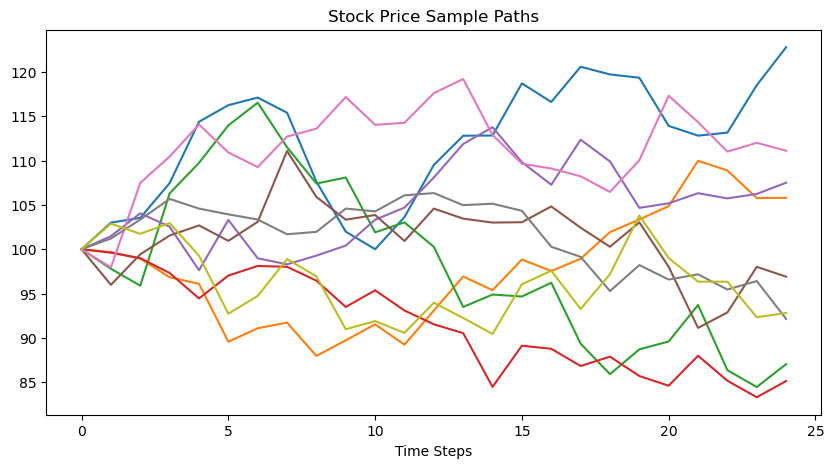

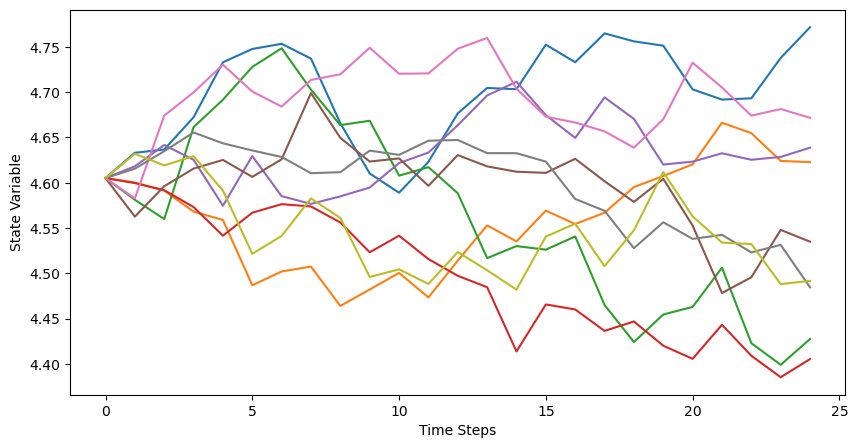

In [6]:
# make two datasets 
starttime = time.time()

# stock price initialization
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0
S_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_1.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))
RN_1 = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

# Generate paths
for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])
    S_1.loc[:,t] = S_1.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN_1.loc[:,t])

# Calculate differences
delta_S = S.iloc[:,1:].values - np.exp(r * delta_t) * S.iloc[:,:-1].values
delta_S_hat = pd.DataFrame(delta_S).apply(lambda x: x - np.mean(x), axis=0)
delta_S_1 = S_1.iloc[:,1:].values - np.exp(r * delta_t) * S_1.iloc[:,:-1].values
delta_S_hat_1 = pd.DataFrame(delta_S_1).apply(lambda x: x - np.mean(x), axis=0)

# state variable
time_array = np.arange(T+1) * delta_t
time_matrix = np.tile(time_array, (N_MC, 1))
X = pd.DataFrame(-1 * (mu - 1/2 * sigma**2) * time_matrix + np.log(S.values.astype(float)), 
                index=S.index, columns=S.columns)
X_1 = pd.DataFrame(-1 * (mu - 1/2 * sigma**2) * time_matrix + np.log(S_1.values.astype(float)), 
                  index=S_1.index, columns=S_1.columns)

# plot paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.figure(figsize=(10, 5))
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

#### Terminal Payoff Function
Define function `terminal_payoff` to compute the terminal payoff of a European put option:

$H_T(S_T) = \max(K - S_T, 0)$

In [8]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

## Define spline basis functions

X.shape =  (1000, 25)
X_min, X_max =  4.126536962389498 5.10037542175207
Number of points k =  17


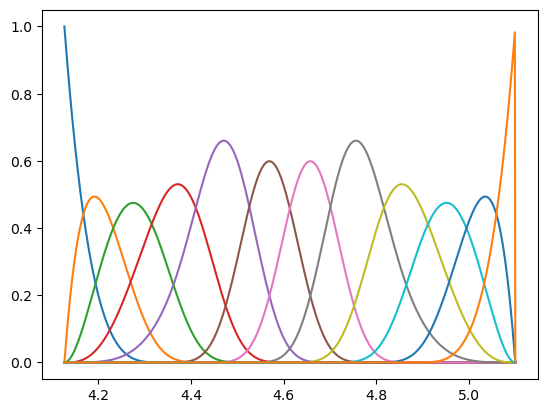

<Figure size 640x480 with 0 Axes>

In [12]:
import bspline
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

p = 4 # order of spline (as-is; 3: cubic, 4: B-spline?)
ncolloc = 12

tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate

# k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
# To get meaninful results, one should have ncolloc >= p+1
k = splinelab.aptknt(tau, p) 
                             
# Spline basis of order p on knots k
basis = bspline.Bspline(k, p)        
f = plt.figure()

print('Number of points k = ', len(k))
basis.plot()

plt.savefig('Basis_functions.png', dpi=600)

In [14]:
type(basis)

bspline.bspline.Bspline

### Make data matrices with feature values
"Features" here are the values of basis functions at data points The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [17]:
num_t_steps = T + 1
num_basis =  ncolloc 

data_mat_t = np.zeros((num_t_steps, N_MC,num_basis ))
data_mat_t_1 = np.zeros((num_t_steps, N_MC,num_basis ))

print('num_basis = ', num_basis)
print('dim data_mat_t = ', data_mat_t.shape)

t_0 = time.time()

# fill it 
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    x_1 = X_1.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(i) for i in x ])
    data_mat_t_1[i,:,:] = np.array([ basis(i) for i in x_1 ])
    
t_end = time.time()
print('Computational time:', t_end - t_0, 'seconds')

num_basis =  12
dim data_mat_t =  (25, 1000, 12)
Computational time: 7.407731533050537 seconds


In [18]:
# save these data matrices for future re-use
np.save('data_mat_m=r_A_%d' % N_MC, data_mat_t)
np.save('data_mat_m=r_B_%d' % N_MC, data_mat_t_1)

print(data_mat_t.shape) # shape: num_steps x N_MC x num_basis
print(len(k))

(25, 1000, 12)
17


#### Dynamic Programming Solution for QLBS

The MDP problem solves the following Bellman optimality equation for the action-value function:

$$
Q_t^*(x,a) = \mathbb{E}_t\left[R_t(X_t,a_t,X_{t+1}) + \gamma \max_{a_{t+1}\in\mathcal{A}} Q_{t+1}^*(X_{t+1},a_{t+1}) \mid X_t = x, a_t = a\right], \quad t=0,\ldots,T-1, \quad \gamma = e^{-r\Delta t}
$$

where $R_t(X_t,a_t,X_{t+1})$ is the one-step time-dependent random reward and $a_t(X_t)$ is the action (hedge).

Using basis functions $\{\Phi_n(X_t^k)\}_{n=1}^N$, expand the optimal action (hedge) $a_t^*(X_t)$ and optimal Q-function $Q_t^*(X_t,a_t^*)$ as:

$$
a_t^*(X_t) = \sum_{n=1}^N \phi_{nt}\Phi_n(X_t) \qquad Q_t^*(X_t,a_t^*) = \sum_{n=1}^N \omega_{nt}\Phi_n(X_t)
$$

Coefficients $\phi_{nt}$ and $\omega_{nt}$ are computed recursively backward in time for $t=T-1,\ldots,0$.

Coefficients for expansions of optimal action $a_t^*(X_t)$ are solved by:

$$
\phi_t = \mathbf{A}_t^{-1}\mathbf{B}_t
$$

where $\mathbf{A}_t$ and $\mathbf{B}_t$ are matrix and vector with elements:

$$
A_{mn}^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_n(X_t^k)\Phi_m(X_t^k)(\Delta S_t^k)^2 \qquad 
B_m^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_m(X_t^k)\left[\Pi_{t+1}^k\Delta S_t^k + \frac{1}{2\gamma\lambda}(\Delta S_t^k)^2\right]
$$

Define functions `function_A` and `function_B` to compute matrix $\mathbf{A}_t$ and vector $\mathbf{B}_t$.

In [22]:
risk_lambda = 0.001 # risk aversion parameter

K = 100 # strike  

# Note that I set coef=0 below in function function_B_vec. This corresponds to a pure risk-based hedging

In [50]:
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    X_mat = data_mat[t,:,:]  # Use passed parameter
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:,t].values
    hat_dS2 = (this_dS**2).reshape(-1,1)    
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat
        
def function_B_vec(t, Pi_hat, delta_S, delta_S_hat, S, data_mat, gamma, risk_lambda):
    coef = 0
    # Convert tmp calculation to use values to ensure proper alignment
    tmp = (Pi_hat.loc[:,t+1].values * delta_S_hat.loc[:,t].values + 
           coef * (np.exp(mu*delta_t) - np.exp(r*delta_t)) * S.loc[:,t].values)
    X_mat = data_mat[t,:,:]
    B = np.dot(X_mat.T, tmp)    
    return B

#### Compute Optimal Hedge and Portfolio Value

Call `function_A` and `function_B` for $t=T-1,\ldots,0$ with basis function $\Phi_n(X_t)$ to compute optimal action $a_t^*(X_t)=\sum_{n=1}^N \phi_{nt}\Phi_n(X_t)$ backward recursively with terminal condition $a_T^*(X_T)=0$.

Once optimal hedge $a_t^*(X_t)$ is computed, portfolio value $\Pi_t$ is computed backward recursively by:

$$
\Pi_t = \gamma[\Pi_{t+1} - a_t^*\Delta S_t] \quad t=T-1,\ldots,0
$$

with terminal condition $\Pi_T = H_T(S_T) = \max(K-S_T,0)$ for a European put option.

Also compute $\hat{\Pi}_t = \Pi_t - \bar{\Pi}_t$, where $\bar{\Pi}_t$ is the sample mean of all values of $\Pi_t$.

Plots of 5 optimal hedge $a_t^*$ and portfolio value $\Pi_t$ paths are shown below.

Computational time: 0.23 seconds


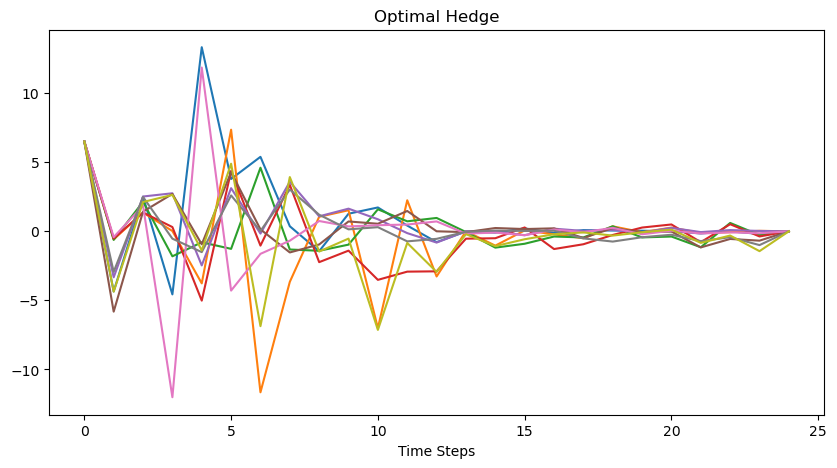

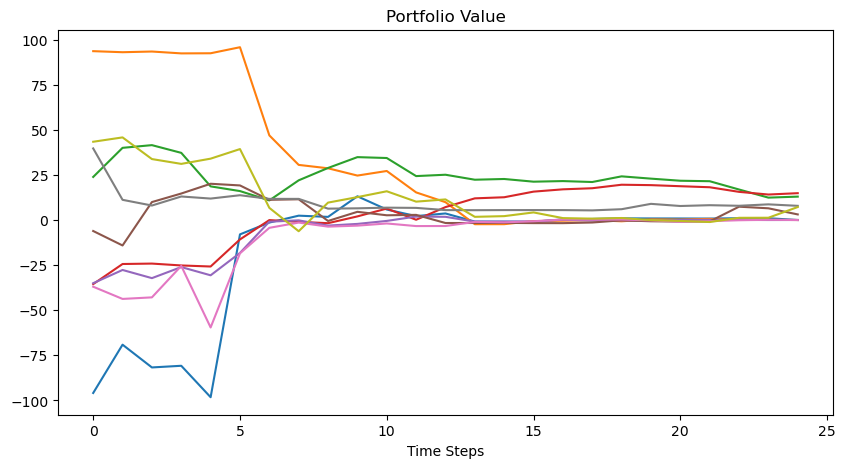

In [61]:
def function_A_vec(t, delta_S_hat, data_mat, reg_param):
    X_mat = data_mat[t,:,:].astype(float)
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.iloc[:,t].values.astype(float)
    hat_dS2 = (this_dS**2).reshape(-1,1)    
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat.astype(float)
        
def function_B_vec(t, Pi_hat, delta_S, delta_S_hat, S, data_mat, gamma, risk_lambda):
    coef = 0
    pi_hat_vals = Pi_hat.iloc[:,t+1].values.astype(float)
    delta_s_hat_vals = delta_S_hat.iloc[:,t].values.astype(float)
    s_vals = S.iloc[:,t].values.astype(float)
    
    tmp = (pi_hat_vals * delta_s_hat_vals + 
           coef * (np.exp(mu*delta_t) - np.exp(r*delta_t)) * s_vals)
    X_mat = data_mat[t,:,:].astype(float)
    B = np.dot(X_mat.T, tmp)    
    return B.astype(float)

# Main computation loop
starttime = time.time()

# Initialize DataFrames with float type explicitly
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
Pi.iloc[:,T] = S.iloc[:,T].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
Pi_hat.iloc[:,T] = Pi.iloc[:,T] - np.mean(Pi.iloc[:,T])

a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
a.iloc[:,T] = 0

# Twin variables with explicit float type
Pi_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
Pi_1.iloc[:,T] = S_1.iloc[:,T].apply(lambda x: terminal_payoff(x, K))

Pi_hat_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
Pi_hat_1.iloc[:,T] = Pi_1.iloc[:,T] - np.mean(Pi_1.iloc[:,T])

a_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1), dtype=float)
a_1.iloc[:,T] = 0

reg_param = 1e-3

for t in range(T-1, -1, -1):
    # First dataset
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
    phi = np.linalg.solve(A_mat, B_vec)
    a.iloc[:,t] = np.dot(data_mat_t[t,:,:].astype(float), phi)
    # Use direct numpy indexing for delta_S since it's a numpy array
    Pi.iloc[:,t] = gamma * (Pi.iloc[:,t+1] - a.iloc[:,t] * delta_S[:,t-1])  # Adjusted indexing for delta_S
    Pi_hat.iloc[:,t] = Pi.iloc[:,t] - np.mean(Pi.iloc[:,t])
    
    # Twin dataset
    A_mat_1 = function_A_vec(t, delta_S_hat_1, data_mat_t_1, reg_param)
    B_vec_1 = function_B_vec(t, Pi_hat_1, delta_S_1, delta_S_hat_1, S_1, data_mat_t_1, gamma, risk_lambda)
    phi_1 = np.linalg.solve(A_mat_1, B_vec_1)
    a_1.iloc[:,t] = np.dot(data_mat_t_1[t,:,:].astype(float), phi_1)
    # Use direct numpy indexing for delta_S_1 since it's a numpy array
    Pi_1.iloc[:,t] = gamma * (Pi_1.iloc[:,t+1] - a_1.iloc[:,t] * delta_S_1[:,t-1])  # Adjusted indexing for delta_S_1
    Pi_hat_1.iloc[:,t] = Pi_1.iloc[:,t] - np.mean(Pi_1.iloc[:,t])

print(f'Computational time: {time.time() - starttime:.2f} seconds')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(a.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Optimal Hedge')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Pi.T.iloc[:,idx_plot])
plt.xlabel('Time Steps')
plt.title('Portfolio Value')
plt.show()

### Reward Function Calculation

Once the optimal hedge $a_t^*$ and portfolio value $\Pi_t$ are computed, the reward function $R_t(X_t, a_t, X_{t+1})$ can be calculated by:

$$R_t(X_t, a_t, X_{t+1}) = \gamma a_t \Delta S_t - \lambda Var[\Pi_t | \mathcal{F}_t], \quad t=0,\ldots,T-1$$

with terminal condition:

$$R_T = -\lambda Var[\Pi_T]$$

Plot of 5 reward function $R_t$ paths is shown below.

### Computing the Optimal Q-function using Dynamic Programming

Coefficients for expansions of the optimal Q-function $Q_t^*(X_t, a_t^*)$ are solved by:

$$\omega_t = C_t^{-1}D_t$$

where $C_t$ and $D_t$ are matrix and vector respectively with elements given by:

$$C_{nm}^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_n(X_t^k)\Phi_m(X_t^k)$$

$$D_n^{(t)} = \sum_{k=1}^{N_{MC}} \Phi_n(X_t^k)\left(R_t(X_t, a_t^*, X_{t+1}) + \gamma \max_{a_{t+1}\in \mathcal{A}} Q_{t+1}^*(X_{t+1}, a_{t+1})\right)$$

Define functions `function_C` and `function_D` to compute the value of matrix $C_t$ and vector $D_t$.

In [67]:
def function_C_vec(t,data_mat_t,reg_param):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]    
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

def function_D_vec(t, Q, R, data_mat_t, gamma=gamma):
    X_mat = data_mat_t[t,:,:]
    tmp = R.loc[:,t] + gamma * Q.loc[:,t+1]  # note that the second argument in Q is t+1 !
    D = np.dot(X_mat.T, tmp.values)
    return D

Call `function_C` and `function_D` for $t = T-1,\ldots,0$ together with basis function $\Phi_n(X_t)$ to compute optimal action Q-function:

$$Q_t^*(X_t,a_t^*) = \sum_n \omega_n\Phi_n(X_t)$$

backward recursively with terminal condition:

$$Q_T^*(X_T,a_T = 0) = -\Pi_T(X_T) - \lambda Var[\Pi_T(X_T)]$$

Compare the QLBS price to European put price given by Black-Scholes formula:

$$C_t^{(BS)} = Ke^{-r(T-t)}N(-d_2) - S_tN(-d_1)$$

In [70]:
# The Black-Scholes prices
def bs_put(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0=S0, K=K, r=r, sigma=sigma, T=M):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

## Hedging and Pricing with Reinforcement Learning

Implement a batch-mode off-policy model-free Q-Learning by Fitted Q-Iteration. The only data available is given by a set of $N_{MC}$ paths for the underlying state variable $X_t$, hedge position $a_t$, instantaneous reward $R_t$ and the next-time value $X_{t+1}$:

$$\mathcal{F}^k = \{(X_t^k, a_t^k, R_t^k, X_{t+1}^k)\}_{t=0}^{T-1} \quad k=1,\ldots,N_{MC}$$

Detailed steps of solving the Bellman optimality equation by Reinforcement Learning are illustrated below.

Expand Q-function in basis functions with time-dependent coefficients parametrized by a matrix $\mathbf{W}_t$:

$$Q_t^*(X_t,a_t) = \mathbf{A}_t^T\mathbf{W}_t\Phi(X_t) = \mathbf{A}_t^T\mathbf{U}_W(t, X_t) = \tilde{W}_t^T\Psi(X_t,a_t)$$

$$\mathbf{A}_t = \begin{pmatrix} 1 \\ a_t \\ \frac{1}{2}a_t^2 \end{pmatrix} \quad \mathbf{U}_W(t, X_t) = \mathbf{W}_t\Phi(X_t)$$

where $\tilde{W}_t$ is obtained by concatenating columns of matrix $\mathbf{W}_t$ while $vec(\Psi(X_t,a_t)) = vec(\mathbf{A}_t \otimes \Phi^T(X))$ stands for a vector obtained by concatenating columns of the outer product of vectors $\mathbf{A}_t$ and $\Phi(X)$.

Compute vector $\mathbf{A}_t$ then compute $\Psi(X_t,a_t)$ for each $X_t^k$ and store in a dictionary with key path and time $[k,t]$.

### Making Off-Policy data

In [80]:
# disturbance level eta: Each action is multiplied by a uniform r.v. in the interval [1-eta, 1 + eta]
eta = 0.1
reg_param = 1e-3

# Initialize DataFrames
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0
a_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op_1.iloc[:,-1] = 0

# Portfolio value initialization
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

Pi_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_1.iloc[:,-1] = S_1.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
Pi_op_hat_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat_1.iloc[:,-1] = Pi_op_1.iloc[:,-1] - np.mean(Pi_op_1.iloc[:,-1])

# Reward function initialization
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])
R_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op_1.iloc[:,-1] = - risk_lambda * np.var(Pi_op_1.iloc[:,-1])

# The backward loop
for t in range(T-1, -1, -1):
    # 1. Compute the optimal policy, and write the result to a_op
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S, delta_S_hat, S, data_mat_t, gamma, risk_lambda)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    A_mat_1 = function_A_vec(t, delta_S_hat_1, data_mat_t_1, reg_param)
    B_vec_1 = function_B_vec(t, Pi_hat_1, delta_S_1, delta_S_hat_1, S_1, data_mat_t_1, gamma, risk_lambda)
    phi_1 = np.dot(np.linalg.inv(A_mat_1), B_vec_1)
    
    a_op.loc[:,t] = np.dot(data_mat_t[t,:,:], phi) 
    a_op_1.loc[:,t] = np.dot(data_mat_t_1[t,:,:], phi_1) 
     
    # 2. Add random disturbance
    noise_factors = np.random.uniform(low=1-eta, high=1+eta, size=N_MC)
    a_op.loc[:, t] = noise_factors * a_op.loc[:, t]
    a_op_1.loc[:, t] = noise_factors * a_op_1.loc[:, t]
    
    # 3. Compute portfolio values for observed actions
    # Convert to numpy arrays for computation
    delta_S_t = delta_S[:,t] if t < T-1 else delta_S[:,-1]  # Handle last timestep
    delta_S_1_t = delta_S_1[:,t] if t < T-1 else delta_S_1[:,-1]
    
    # Portfolio value calculations
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1].values - 
                             (a_op.loc[:,t].values * delta_S_t))
    Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
    
    Pi_op_1.loc[:,t] = gamma * (Pi_op_1.loc[:,t+1].values - 
                               (a_op_1.loc[:,t].values * delta_S_1_t))
    Pi_op_hat_1.loc[:,t] = Pi_op_1.loc[:,t] - np.mean(Pi_op_1.loc[:,t])
    
    # Compute rewards for observed actions
    # Convert to numpy arrays for computation to ensure proper broadcasting
    R_op.loc[:,t] = (gamma * a_op.loc[:,t].values * delta_S_t - 
                     risk_lambda * np.var(Pi_op.loc[:,t]))
    R_op_1.loc[:,t] = (gamma * a_op_1.loc[:,t].values * delta_S_1_t - 
                       risk_lambda * np.var(Pi_op_1.loc[:,t]))
    
print('done!')

done!


###  Now override on-policy data with off-policy data

In [83]:
a = a_op.copy()
a_1 = a_op_1.copy()

Pi = Pi_op.copy()
Pi_hat = Pi_op_hat.copy()
Pi_1 = Pi_op_1.copy()
Pi_hat_1 = Pi_op_hat_1.copy()

R = R_op.copy()
R_1 = R_op_1.copy()
# make matrix A_t of shape (3 x num_MC x num_steps)

num_MC = a.shape[0]
a_1_1 = a.values.reshape((1,num_MC,25))

a_1_2 = 0.5 * a_1_1**2
ones_3d = np.ones((1,num_MC, 25))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

# and the same for the second dataset:
a_2_1 = a_1.values.reshape((1,num_MC,25))
a_2_2 = 0.5 * a_2_1**2
A_stack_1 = np.vstack((ones_3d, a_2_1, a_2_2))

print(A_stack.shape, A_stack_1.shape)

(3, 1000, 25) (3, 1000, 25)


In [85]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)
data_mat_swap_idx_1 = np.swapaxes(data_mat_t_1,0,2)

print(data_mat_swap_idx.shape) # (12, 10000, 25)

# expand dimensions of matrices to multiply element-wise
A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,10000,25)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,10000,25)

Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

# the same for the twin dataset
A_2_1 = np.expand_dims(A_stack_1, axis=1)
data_mat_swap_idx_1 = np.expand_dims(data_mat_swap_idx_1, axis=0)

Psi_mat_1 = np.multiply(A_2_1, data_mat_swap_idx_1) # this is a matrix of size 3 x num_basis x num_MC x num_steps

# now concatenate columns along the first dimension
Psi_mat_1 = Psi_mat_1.reshape(-1, N_MC, T+1, order='F')

print(Psi_mat.shape, Psi_mat_1.shape)

(12, 1000, 25)
(36, 1000, 25) (36, 1000, 25)


In [87]:
# make matrix S_t 

Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
print(Psi_1_aux.shape, Psi_2_aux.shape)

S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) 

Psi_1_aux_1 = np.expand_dims(Psi_mat_1, axis=1)
Psi_2_aux_1 = np.expand_dims(Psi_mat_1, axis=0)
print(Psi_1_aux_1.shape, Psi_2_aux_1.shape)

S_t_mat_1 = np.sum(np.multiply(Psi_1_aux_1, Psi_2_aux_1), axis=2) 
print(S_t_mat.shape, S_t_mat_1.shape)

(36, 1, 1000, 25) (1, 36, 1000, 25)
(36, 1, 1000, 25) (1, 36, 1000, 25)
(36, 36, 25) (36, 36, 25)


In [89]:
del Psi_1_aux, Psi_2_aux, Psi_1_aux_1, Psi_2_aux_1, data_mat_swap_idx,data_mat_swap_idx_1, A_2, A_2_1 


Vector $\tilde{W}_t$ could be solved by:

$$\tilde{W}_t = \mathbf{S}_t^{-1}\mathbf{M}_t$$

where $\mathbf{S}_t$ and $\mathbf{M}_t$ are matrix and vector respectively with elements given by:

$$S_{nm}^{(t)} = \sum_{k=1}^{N_{MC}} \Psi_n(X_t^k, a_t^k)\Psi_m(X_t^k, a_t^k)$$

$$M_n^{(t)} = \sum_{k=1}^{N_{MC}} \Psi_n(X_t^k, a_t^k)\left(R_t(X_t, a_t, X_{t+1}) + \gamma \max_{a_{t+1}\in \mathcal{A}} Q_{t+1}^*(X_{t+1}, a_{t+1})\right)$$

Define functions `function_S` and `function_M` to compute the value of matrix $\mathbf{S}_t$ and vector $\mathbf{M}_t$.

In [92]:
# vectorized functions

def function_S_vec(t,S_t_mat,reg_param):
    # Compute the matrix S_{nm} from Eq. (75) (with a regularization!)
    S_mat = S_t_mat[:,:,t]     
    S_mat_reg = S_mat + reg_param * np.eye(S_mat.shape[0])
    return S_mat_reg

# this function requires some refinement!
def function_M_vec(t,
                   Q_star, # max_Q_star, 
                   R, 
                   Psi_mat_t,  # 2D array of dimension 3M x num_MC 
                   gamma=gamma):
    
    # Psi_mat = Psi_mat_t[:,:,t]   # 2D array of dimension 3M x num_MC 
    tmp = R.loc[:,t] + gamma * Q_star.iloc[:,t+1]
    M_t = np.dot(Psi_mat_t, tmp.values)
    return M_t

Call `function_S` and `function_M` for $t = T-1,\ldots,0$ together with vector $\Psi(X_t, a_t)$ to compute $\tilde{W}_t$ and learn the Q-function $Q_t^*(X_t,a_t) = \mathbf{A}_t^T\mathbf{U}_W(t, X_t)$ implied by the input data backward recursively with terminal condition $Q_T^*(X_T,a_T = 0) = -\Pi_T(X_T) - \lambda Var[\Pi_T(X_T)]$.

When the vector $\tilde{W}_t$ is computed as per the above at time $t$, we can convert it back to a matrix $\mathbf{W}_t$ obtained from the vector $\tilde{W}_t$ by reshaping to the shape $3 \times M$.

We can now calculate the matrix $\mathbf{U}_t$ at time $t$ for the whole set of MC paths as follows (this is Eq.(65) from the paper in a matrix form):

$$\mathbf{U}_W(t, X_t) = \begin{bmatrix} \mathbf{U}_W^{0,k}(t, X_t) \\ \mathbf{U}_W^{1,k}(t, X_t) \\ \mathbf{U}_W^{2,k}(t, X_t) \end{bmatrix} = \mathbf{W}_t\Phi_t(t, \mathbf{X}_t)$$

Here the matrix $\Phi_t$ has the shape $M \times N_{MC}$. Therefore, their dot product has dimension $3 \times N_{MC}$, as it should be.

Once this matrix $\mathbf{U}_t$ is computed, individual vectors $\mathbf{U}_W^0$, $\mathbf{U}_W^1$, $\mathbf{U}_W^2$ for all MC paths are read off as rows of this matrix.

From here, we can compute the optimal action and optimal Q-function $Q^*(X_t,a_t^*)$ at the optimal action for a given step $t$. This will be used to evaluate the $\max_{a_{t+1}\in \mathcal{A}}Q^*(X_{t+1}, a_{t+1})$.

The optimal action and optimal Q-function with the optimal action could be computed by:

$$a_t^*(X_t) = -\frac{\mathbb{E}_t[\Delta \hat{S}_t\Pi_{t+1} + \frac{1}{2\gamma}\Delta S_t]}{\mathbb{E}_t[(\Delta \hat{S}_t)^2]}, \quad Q_t^*(X_t,a_t^*) = \mathbf{U}_W^{(0)}(t, X_t) + a_t^*\mathbf{U}_W^{(2)}(t, X_t) + \frac{1}{2}(a_t^*)^2\mathbf{U}_W^{(2)}(t, X_t)$$

with terminal condition $a_T^* = 0$ and $Q_T^*(X_T,a_T^* = 0) = -\Pi_T(X_T) - \lambda Var[\Pi_T(X_T)]$.

Plots of 5 optimal action $a_t^*(X_t)$, optimal Q-function with optimal action $Q_t^*(X_t,a_t^*)$ and implied Q-function $Q_t^*(X_t,a_t)$ paths are shown below.

### Fitted G-Iteration


Time Cost: 0.3407905101776123 seconds


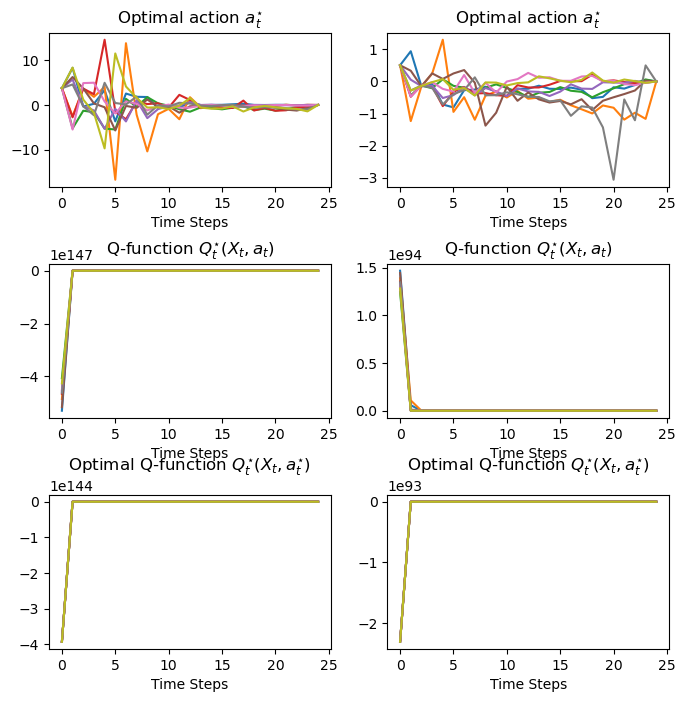

In [104]:
def function_S_vec(t, Psi, reg_param):
    """
    Compute matrix S_t with elements S_{nm}^(t) = sum_k Psi_n(X_t^k, a_t^k)Psi_m(X_t^k, a_t^k)
    """
    # Psi should have dimension 3M x N_MC for time t
    Psi_t = Psi[:,:,t]  # Get the matrix for time t
    
    # Compute S matrix directly using matrix multiplication
    S_mat = np.dot(Psi_t, Psi_t.T).astype(float)
    
    # Add regularization
    S_mat += reg_param * np.eye(S_mat.shape[0])
    
    return S_mat

def function_M_vec(t, Q_star, R, Psi_t, gamma):
    """
    Compute vector M_t with elements M_n^(t) = sum_k Psi_n(X_t^k, a_t^k)(R_t + gamma * max_a Q_{t+1})
    """
    # Get reward at time t
    R_t = R.iloc[:,t].values
    
    # Get max Q value for next time step
    if t < T-1:
        Q_next = Q_star.iloc[:,t+1].values
    else:
        Q_next = np.zeros_like(R_t)
    
    # Compute target values
    target = R_t + gamma * Q_next
    
    # Compute M vector
    M_vec = np.dot(Psi_t, target).astype(float)
    
    return M_vec

# Pre-compute Psi matrices
def compute_psi_matrix(data_mat, a_values):
    """
    Compute Psi matrix for all time steps
    """
    T = data_mat.shape[0]
    N_MC = data_mat.shape[1]
    num_basis = data_mat.shape[2]
    
    # Initialize Psi matrix with shape (3*num_basis) x N_MC x T
    Psi_mat = np.zeros((3*num_basis, N_MC, T))
    
    for t in range(T):
        for k in range(N_MC):
            # Get basis functions for this time and path
            phi_tk = data_mat[t,k,:]
            a_tk = a_values.iloc[k,t]
            
            # Compute A vector
            A_tk = np.array([1, a_tk, 0.5*a_tk**2])
            
            # Compute outer product
            psi_tk = np.kron(A_tk, phi_tk)
            
            # Store in matrix
            Psi_mat[:,k,t] = psi_tk
            
    return Psi_mat

# Pre-compute Psi matrices for both datasets
Psi_mat = compute_psi_matrix(data_mat_t, a_op)
Psi_mat_1 = compute_psi_matrix(data_mat_t_1, a_op_1)

starttime = time.time()

# implied Q-function by input data (using the first form in Eq.(68))
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# similar variables for the twin dataset:
Q_RL_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL_1.iloc[:,-1] = - Pi_1.iloc[:,-1] - risk_lambda * np.var(Pi_1.iloc[:,-1])

# optimal action
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal action
a_opt_1 = np.zeros((N_MC,T+1))
a_star_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star_1.iloc[:,-1] = 0

# optimal Q-function with optimal action
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

# optimal Q-function with optimal action
Q_star_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star_1.iloc[:,-1] = Q_RL_1.iloc[:,-1]

max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

max_Q_star_1 = np.zeros((N_MC,T+1))
max_Q_star_1[:,-1] = Q_RL_1.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

# Inside the backward loop:
for t in range(T-1, -1, -1):
    # calculate vector W_t
    S_mat_reg = function_S_vec(t,S_t_mat,reg_param) 
    M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M
    
    # reshape to a matrix W_mat  
    W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M 
        
    # make matrix Phi_mat
    Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

    # compute matrix U_mat of dimension N_MC x 3 
    U_mat = np.dot(W_mat, Phi_mat)
    
    # twin variables for the twin dataset:
    S_mat_reg_1 = function_S_vec(t,S_t_mat_1,reg_param) 
    M_t_1 = function_M_vec(t,Q_star_1, R_1, Psi_mat_1[:,:,t], gamma)
    W_t_1 = np.dot(np.linalg.inv(S_mat_reg_1),M_t_1)
    W_mat_1 = W_t_1.reshape((3, num_basis), order='F')
    Phi_mat_1 = data_mat_t_1[t,:,:].T
    U_mat_1 = np.dot(W_mat_1, Phi_mat_1)
    
    # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat  
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]
    
    U_W_0_1 = U_mat_1[0,:]
    U_W_1_1 = U_mat_1[1,:]
    U_W_2_1 = U_mat_1[2,:]
     
    # Use hedges computed as in DP approach
    A_mat = function_A_vec(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B_vec(t, Pi_hat, delta_S, delta_S_hat, S, data_mat_t, gamma, risk_lambda)  # Added all required arguments
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    
    A_mat_1 = function_A_vec(t, delta_S_hat_1, data_mat_t_1, reg_param)
    B_vec_1 = function_B_vec(t, Pi_hat_1, delta_S_1, delta_S_hat_1, S_1, data_mat_t_1, gamma, risk_lambda)  # Added all required arguments
    phi_1 = np.dot(np.linalg.inv(A_mat_1), B_vec_1)
    
    # Rest of the code remains the same...
    
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 
    
    a_opt_1[:,t] = np.dot(data_mat_t_1[t,:,:],phi_1)
    a_star_1.loc[:,t] = a_opt_1[:,t] 
    
    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2 
    max_Q_star_1[:,t] = U_W_0_1 + a_opt_1[:,t] * U_W_1_1 + 0.5 * (a_opt_1[:,t]**2) * U_W_2_1 
      
    # update dataframes     
    Q_star.loc[:,t] = max_Q_star[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    a_star_1.loc[:,t] = a_opt_1[:,t] 
    Q_star_1.loc[:,t] = max_Q_star_1[:,t]
    
    # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
    Psi_t_1 = Psi_mat_1[:,:,t].T  # dimension N_MC x 3M  
    Q_RL_1.loc[:,t] = np.dot(Psi_t_1, W_t_1)
    
    # trim outliers for Q_RL
    up_percentile_Q_RL =  95 # 95
    low_percentile_Q_RL = 5 # 5
    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # trim outliers in values of max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL
    
    low_perc_Q_RL_1, up_perc_Q_RL_1 = np.percentile(Q_RL_1.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
   
    # trim outliers in values of max_Q_star:
    flag_lower_1 = Q_RL_1.loc[:,t].values < low_perc_Q_RL_1
    flag_upper_1 = Q_RL_1.loc[:,t].values > up_perc_Q_RL_1
    Q_RL_1.loc[flag_lower_1,t] = low_perc_Q_RL_1
    Q_RL_1.loc[flag_upper_1,t] = up_perc_Q_RL_1
    
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

f, axarr = plt.subplots(3, 2)
f.subplots_adjust(hspace=.5)
f.set_figheight(8.0)
f.set_figwidth(8.0)

step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
axarr[0, 0].plot(a_star.T.iloc[:, idx_plot]) 
axarr[0, 0].set_xlabel('Time Steps')
axarr[0, 0].set_title(r'Optimal action $a_t^{\star}$')

axarr[0, 1].plot(a_star_1.T.iloc[:, idx_plot]) 
axarr[0, 1].set_xlabel('Time Steps')
axarr[0, 1].set_title(r'Optimal action $a_t^{\star}$')

axarr[1, 0].plot(Q_RL.T.iloc[:, idx_plot]) 
axarr[1, 0].set_xlabel('Time Steps')
axarr[1, 0].set_title(r'Q-function $Q_t^{\star} (X_t, a_t)$')

axarr[1, 1].plot(Q_RL_1.T.iloc[:, idx_plot]) 
axarr[1, 1].set_xlabel('Time Steps')
axarr[1, 1].set_title(r'Q-function $Q_t^{\star}(X_t, a_t)$')

axarr[2, 0].plot(Q_star.T.iloc[:, idx_plot]) 
axarr[2, 0].set_xlabel('Time Steps')
axarr[2, 0].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$') 

axarr[2, 1].plot(Q_star_1.T.iloc[:, idx_plot]) 
axarr[2, 1].set_xlabel('Time Steps')
axarr[2, 1].set_title(r'Optimal Q-function $Q_t^{\star} (X_t, a_t^{\star})$')

plt.savefig('QLBS_FQI_off_policy_summary_ATM_eta_%d.png' % (100 * eta), dpi=600);

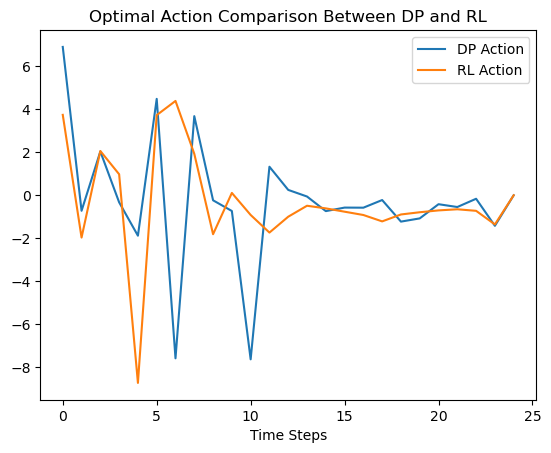

In [106]:
# plot a and a_star
# plot 1 path

num_path =  120

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()